In [1]:
import sys
import os
import numpy as np
import pandas as pd
import os
import json
import pathlib
import matplotlib.pyplot as plt
import re

sys.path.append("../../../")

import src.models

FOLDER_NAME = "exp5_nodule"
MODELS = [
    src.models.MNIST3dLiqExp5N1(),
    src.models.MNIST3dLSTMExp5N2(),
    src.models.MNIST3dLSTMExp5N3(),
    src.models.MNIST3dLSTMExp5N4(),
    src.models.MNIST3dRNNExp5N5(),
    src.models.MNIST3dRNNExp5N6(),
]


alloc!


In [2]:
num_models = len(os.listdir(pathlib.Path("./saved_models/") / FOLDER_NAME))


labels = []
all_model_metrics = {}
final_model_metrics = {}
for i in range(num_models):
    val_metrics_res = {"loss": [], "acc": [], "roc_auc": []}
    test_metrics_res = {"loss": [], "acc": [], "roc_auc": []}
    labels.append(MODELS[i].name)

    cur_dir = pathlib.Path("./saved_models/") / FOLDER_NAME / str(i)
    files = os.listdir(cur_dir)
    files.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    for file_name in files:
        if "val.json" in file_name:
            with open(cur_dir / file_name) as f:
                val_metrics = json.load(f)
            val_metrics_res["loss"].append(val_metrics["val_loss"])
            val_metrics_res["acc"].append(val_metrics["val_acc"])
            val_metrics_res["roc_auc"].append(val_metrics["val_roc_auc"])

        elif "test.json" in file_name:
            with open(cur_dir / file_name) as f:
                test_metrics = json.load(f)
            test_metrics_res["loss"].append(test_metrics["val_loss"])
            test_metrics_res["acc"].append(test_metrics["val_acc"])
            test_metrics_res["roc_auc"].append(test_metrics["val_roc_auc"])

        else:
            continue
    final_model_metrics[MODELS[i].name] = [test_metrics_res["loss"][-1], test_metrics_res["acc"][-1], test_metrics_res["roc_auc"][-1]]
    all_model_metrics[i] = {"val": val_metrics_res, "test": test_metrics_res}

final_model_metrics_df = pd.DataFrame(final_model_metrics, index=["loss", "acc", "roc_auc"]).T

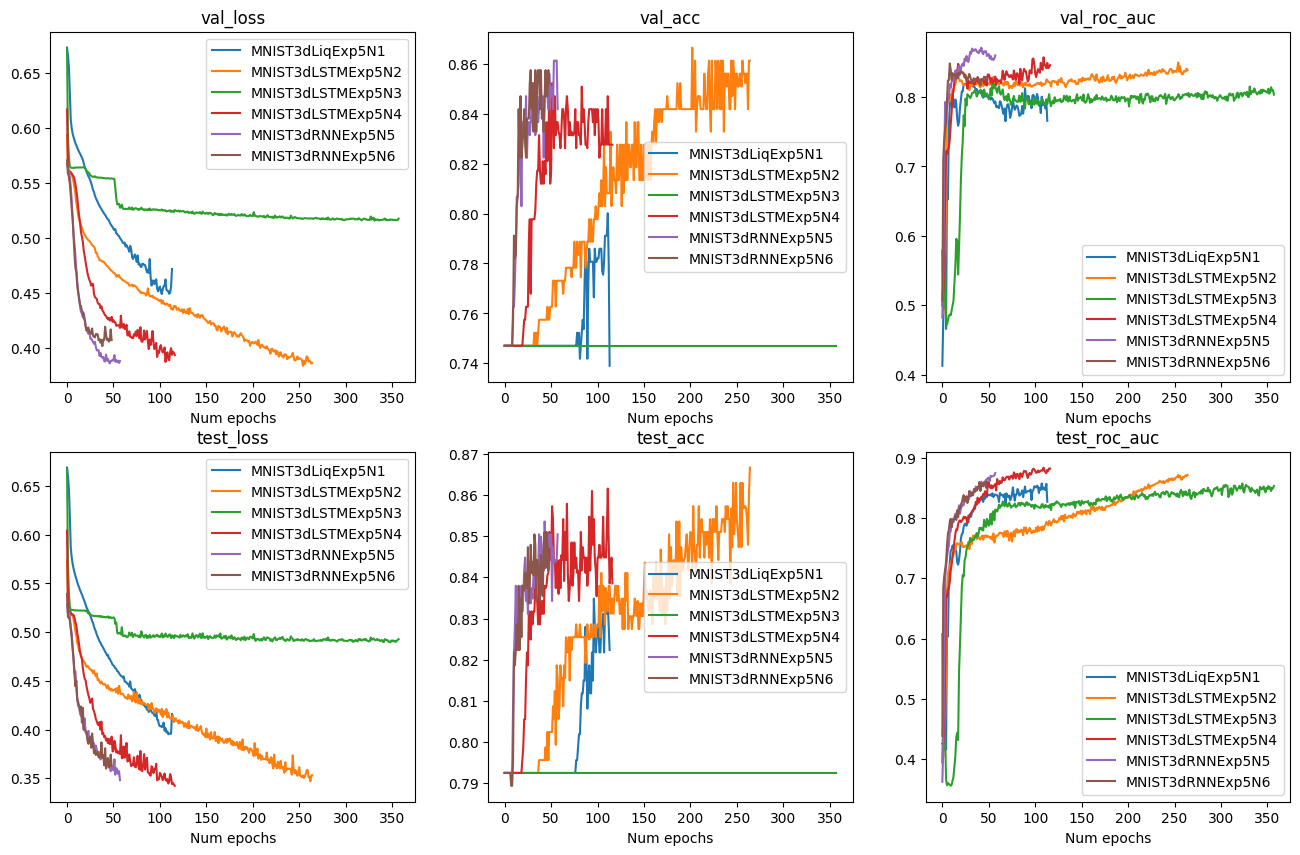

In [3]:
plt.figure(figsize=(16, 10))

for col, mode in enumerate(["val", "test"]):
    for row, metric in enumerate(["loss", "acc", "roc_auc"]):
        plt.subplot(2, 3, col * 3 + row + 1)
        for i in range(num_models):
            x = np.arange(len(all_model_metrics[i][mode][metric]))
            y = np.array(all_model_metrics[i][mode][metric])
            plt.plot(x, y)
            plt.legend(labels)
            plt.title(f"{mode}_{metric}")
            plt.xlabel("Num epochs")
plt.show()

In [4]:
all_model_parameters = []
for i in range(num_models):
     model_parameters = filter(lambda p: p.requires_grad, MODELS[i].parameters())
     all_model_parameters.append(sum([np.prod(p.size()) for p in model_parameters]))

final_model_metrics_df["parameters"] = all_model_parameters

In [5]:
file_name = pathlib.Path(f"metrics_{FOLDER_NAME.split('_')[-1]}.csv")
file_exists = file_name.exists()

final_model_metrics_df.to_csv(file_name, mode="a", header=not file_exists)
final_model_metrics_df

,loss,acc,roc_auc,parameters
MNIST3dLiqExp5N1,0.415904,0.822338,0.827045,9953
MNIST3dLSTMExp5N2,0.353097,0.866667,0.871316,71797
MNIST3dLSTMExp5N3,0.492792,0.792477,0.853087,71928
MNIST3dLSTMExp5N4,0.342315,0.838542,0.881987,84917
MNIST3dRNNExp5N5,0.348143,0.850463,0.874619,18757
MNIST3dRNNExp5N6,0.362827,0.845370,0.860645,22037


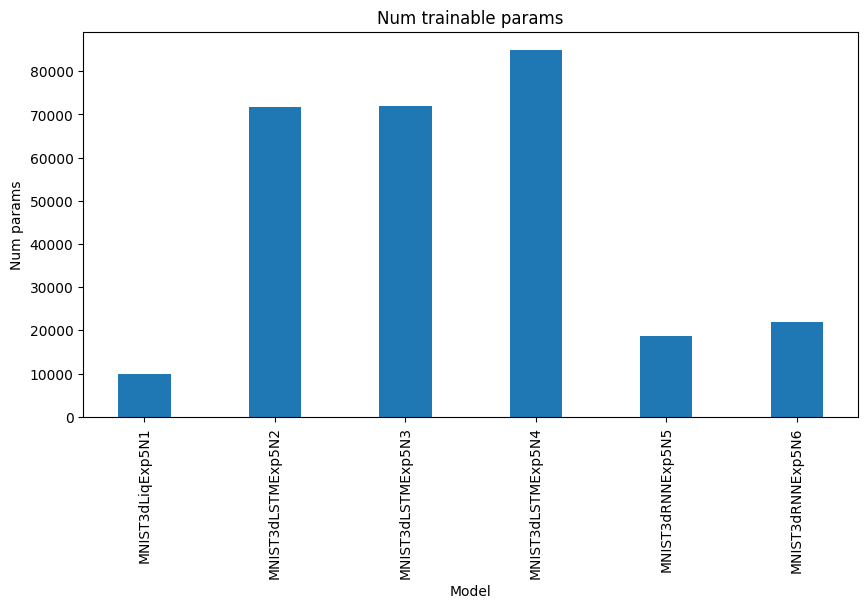

In [6]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(
    [model.name for model in MODELS],
    all_model_parameters, 
    width = 0.4,
)
 
plt.xlabel("Model")
plt.xticks(rotation='vertical')
plt.ylabel("Num params")
plt.title("Num trainable params")
plt.show()